# _Recommendation System_

## . Import Libraries

In [1]:
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager

In [2]:
# Libraries neeeded to work on the data
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy.stats as stats
import seaborn as sns
import pickle
import sklearn.metrics as metrics
from keras import backend as K

from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [3]:
import warnings
warnings.filterwarnings('ignore')


# Dataset has 271361 rows, jupyter notebook is crashing 
#if I don't limit the number of rows displayed below.
pd.set_option('display.max_columns', 1000) 
pd.set_option('display.max_rows', 1000)
pd.options.display.max_columns = 1000

##  . _Import Data_

In [4]:
books = pd.read_csv('books_final.csv')

In [5]:
ratings = pd.read_csv('ratings_final.csv')

In [6]:
users = pd.read_csv('users_final.csv')

In [8]:
df = pd.read_csv('preprocessed_data.csv')

##  . _Data Exploring_

Explore and check the dataset, it is necessary to know your dataset before starting cleaning or 
dropping information.

In [63]:
books.shape

(271359, 6)

In [64]:
ratings.shape

(1149780, 4)

In [65]:
users.shape

(278858, 7)

Type of data:

In [66]:
ratings['book_rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

## _Pre-processing_

Explore and check the dataset .

 - Ratings dataset should only have books only which exist in our books dataset. Drop the remaining rows
 - Ratings dataset should have ratings from users which exist in users dataset. Drop the remaining rows
 - Consider only ratings from 1-10 and leave 0s in column bookRating
 
Find out which rating has been given highest number of times

Ratings dataset will have n_users*n_books entries if every user rated every item,this shows that the dataset is very sparse Ratings dataset will have users * books number of records

In [14]:
n_users = users.shape[0]
n_books = books.shape[0]
n_users * n_books

75670628022

In [15]:
n_users = users.shape[0]
n_books = books.shape[0]
n_users * n_books

75670628022

In [16]:
ratings.head(10)

,Unnamed: 0,user_id,isbn,book_rating
0,0,276725,034545104X,0
1,1,276726,0155061224,5
2,2,276727,0446520802,0
3,3,276729,052165615X,3
4,4,276729,0521795028,6
5,5,276733,2080674722,0
6,6,276736,3257224281,8
7,7,276737,0600570967,6
8,8,276744,038550120X,7
9,9,276745,342310538,10


In [17]:
ratings['book_rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

Ratings dataset should have only books which exist in our books dataset, unless new books are added to the dataset.

In [18]:
ratings_new = ratings[ratings.isbn.isin(books.isbn)]

ratings.shape,ratings_new.shape

((1149780, 4), (1031135, 4))

We can see that many rows are having book isbn not part of books dataset got dropped off.

Ratings dataset should have ratings from users which exist in users dataset, unless new users are added to users dataset

In [19]:
ratings = ratings[ratings['user_id'].isin(users['user_id'])]

print(ratings.shape)
print(ratings_new.shape)

(n_users), (n_books)

(1149780, 4)
(1031135, 4)


(278858, 271359)

There is no new users added, so we will use the dataset above ratings_new (1031136, 3)

### _Sparsity :_

Some users have rated books which are not part of original books dataset. Sparsity of the dataset can be calculated as below:

In [20]:
sparsity=1.0-len(ratings_new)/float(n_users*n_books)
print ('Sparsity level of book dataset is ' + str(sparsity*100) + ' %')

Sparsity level of book dataset is 99.99863733785888 %


### _Implicit and explict ratings_

Checking rating distribution.As shown bellow we have a lot of zero rating which are no use for our analysis

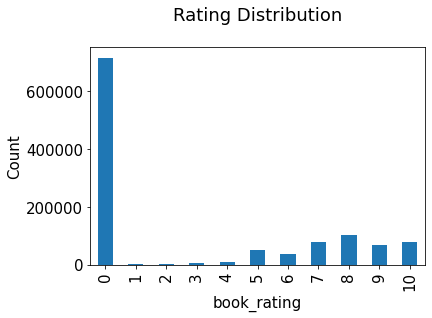

In [21]:
plt.rc("font", size=15)
ratings.book_rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('book_rating')
plt.ylabel('Count')
plt.show()

Segragating implicit and explict ratings datasets : 

   - explicit ratings is represented by 1–10
   - implicit ratings is represented by 0 
 (Removing the zero.)

In [24]:
ratings_explicit = ratings_new[ratings_new.book_rating != 0]
ratings_implicit = ratings_new[ratings_new.book_rating == 0]

Checking shapes :

In [25]:
print(ratings_new.shape)
print(ratings_explicit.shape)
print(ratings_implicit.shape)

(1031135, 4)
(383841, 4)
(647294, 4)


Plotting count of book_rating :

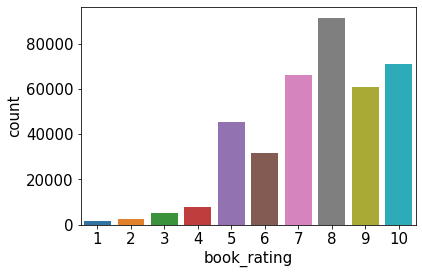

In [26]:
sns.countplot(data=ratings_explicit , x='book_rating')
plt.show();

The highest ratings are more used and rating height is the rating mostly present.

### _Users_

In [50]:
users_exp_ratings = users[users.user_id.isin(ratings_explicit.user_id)]
users_imp_ratings = users[users.user_id.isin(ratings_implicit.user_id)]

In [52]:
print (users.shape)
print (users_exp_ratings.shape)
print (users_imp_ratings.shape)

(278858, 7)
(68091, 7)
(52451, 7)


## _Recommendation systems_

What actually is Recommendation System
A recommendation engine is a class of machine learning which offers relevant suggestions to the customer.  Before the recommendation system, the major tendency to buy was to take a suggestion from friends. But Now Google knows what news you will read, Youtube knows what type of videos you will watch based on your search history, watch history, or purchase history.

A recommendation system helps an organization to create loyal customers and build trust by them desired products and services for which they came on your site. The recommendation system today are so powerful that they can handle the new customer too. They recommend the products which are currently trending or highly rated and they can also recommend the products which bring maximum profit to the company.

### _Types Of Recommendation System :_

A recommendation system is usually built using techniques which are content-based filtering, collaborative filtering, and a combination of both.

   - Simple recommenders: 

Generalized recommendations to every user, based on book popularity and/or genre. The basic idea behind this system is that books that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

   - Content-Based Filtering :

The algorithm recommends a product that is similar to those which used as watched. In simple words, In this algorithm, we try to find item which look alike (similar ages, categories ...).

 it only looked at the similarity between the content and does not focus on the person who is reading it. this system recommends the book which has the highest score based on past preferences.


   - Collaborative-based Filtering :

Collaborative based filtering recommender systems are based on past interactions of users and target items.  In simple words here, we try to search for the look-alike customers and offer products based on what his or her lookalike has chosen. 

Exemple : Youtube 


   - Hybrid Filtering Method :

It is basically a combination of both of the above methods. It is a too complex model which recommends product based on your history as well as based on similar users.

Exemple : Facebook, Linkedin.


Book Recommendation System:
A book recommendation system is a type of recommendation system where we have to recommend similar books to the reader based on his interest. The books recommendation system is used by online websites which provide ebooks like google play books, open library, good Read’s, etc.

### _Simple Popularity based Recommendation System_

#### _Recommendations based on ratings_

In [55]:
ratings_count = pd.DataFrame(ratings_explicit.groupby(['isbn'])['book_rating'].sum())
top10 = ratings_count.sort_values('book_rating', ascending = False).head(10)
print ("Top 10 books (with highest ratings):")
top10.merge(books, left_index = True, right_on = 'isbn')

Top 10 books (with highest ratings):


,book_rating,Unnamed: 0,isbn,book_title,book_author,year_of_publication,publisher
408,5787,408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
748,4108,748,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,3134,522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
2143,2798,2143,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
356,2595,356,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
26,2551,26,0971880107,Wild Animus,Rich Shapero,2004,Too Far
1105,2524,1105,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
706,2402,706,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books
231,2219,231,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
118,2179,118,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


#### _Recommendation based on popularity_

In [54]:
rating_count = pd.DataFrame(ratings.groupby('isbn')['book_rating'].count())
top10_most_rated = rating_count.sort_values('book_rating', ascending=False).head(10)
print ("Top 10 books (in number of ratings):")
top10_most_rated.merge(books, left_index = True, right_on = 'isbn')

Top 10 books (in number of ratings):


,book_rating,Unnamed: 0,isbn,book_title,book_author,year_of_publication,publisher
26,2502,26,0971880107,Wild Animus,Rich Shapero,2004,Too Far
408,1295,408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
748,883,748,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
1105,732,1105,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
522,723,522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
305,647,305,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company
356,615,356,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
1922,614,1922,067976402X,Snow Falling on Cedars,David Guterson,1995,Vintage Books USA
118,586,118,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


### _Collaborative Filtering based Recommendation System/Recommendations based on correlations_

In [56]:
average_rating = pd.DataFrame(ratings.groupby('isbn')['book_rating'].mean())
average_rating['rating_count'] = pd.DataFrame(ratings.groupby('isbn')['book_rating'].count())
average_rating.sort_values('rating_count', ascending=False).head()

,book_rating,rating_count
isbn,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


For more accurate results only consider users who have rated atleast 100 books

In [57]:
counts1 = ratings_explicit['user_id'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['user_id'].isin(counts1[counts1 >= 100].index)]
counts = ratings_explicit['book_rating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['book_rating'].isin(counts[counts >= 100].index)]

In [58]:
ratings_explicit.shape

(103271, 4)

In [59]:
ratings_matrix = ratings_explicit.pivot(index='user_id', columns='isbn', values='book_rating').fillna(0)
user_id = ratings_matrix.index
isbn = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(449, 66574)


isbn,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,0001056107,0001845039,0001935968,0001944711,0001952803,0001953877,0002000547,0002005018,0002005050,0002005557,0002006588,0002115328,0002116286,0002118580,0002154900,0002158973,0002163713,0002176181,0002176432,0002179695,0002181924,0002184974,0002190915,0002197154,0002223929,0002228394,000223257X,0002233509,0002239183,0002240114,0002241358,0002244098,0002245728,000225056X,0002250810,0002251000,0002251485,0002251760,0002252341,0002252376,0002253372,0002255014,0002255081,0002258560,000225929X,0002259877,0002316196,0002317141,0002325780,0002550563,0002551195,0002551675,0002553384,0002554119,0002554283,0002555565,0002558122,0002558661,0002712172,0002726874,0003300277,0004125576,0004133439,0004334787,000433549X,0004356373,0004588010,0004588177,0004701674,0004702816,0004704746,0004704754,0004704932,0004708105,0004709721,000470973X,0004720164,0004720695,0004722124,0004723708,0004724097,0004725042,000611962X,0006131409,0006143199,0006156487,0006157629,0006166598,0006171982,0006174841,0006175317,0006176747,0006176992,0006177492,0006178316,0006271197,0006279945,0006280803,0006363113,0006363121,0006365744,0006366023,0006370039,0006370829,0006371248,0006372899,0006375952,0006379702,0006380263,0006380921,0006380964,0006383777,0006384684,0006384722,0006384854,0006385370,0006385648,0006386369,0006472648,000647425X,0006480608,000648302X,0006485200,0006485936,0006490603,0006492126,0006492347,0006497993,000649840X,0006498493,000651202X,000651202x,0006512062,0006512143,0006512208,0006512801,0006514952,0006531407,0006542808,0006543545,0006544959,0006546684,0006547486,0006547613,0006547753,0006547834,0006548180,0006548539,0006548830,0006550061,0006550576,0006550789,0006550924,0006551076,0006551971,0006552390,0006726143,0006729835,000673765X,0006742939,0006742947,0006754864,0006928323,0006940889,0007100108,0007100930,0007102216,000710331X,0007103352,0007103360,0007103867,0007105150,0007105665,0007106572,000710698X,0007107900,0007110200,0007110227,0007110928,0007114788,0007116993,000711737X,0007117507,0007118465,0007119070,0007119860,000712032X,0007122039,0007122861,0007127936,0007128568,0007128576,0007139411,0007141076,0007144172,0007144350,000715111X,0007154607,0007154615,000716226X,0007164076,0007176023,000764065X,0020009607,0020016700,0020088248,0020093616,0020103514,002011690X,0020125305,0020125607,0020154402,0020155506,0020182104,0020188706,0020197802,0020198817,0020198841,0020198906,0020199031,0020199600,0020199856,0020209851,0020223412,0020223722,0020225601,0020248717,0020259913,0020264763,002026478X,0020264801,0020264852,0020280505,002028361X,0020296703,0020296800,0020299605,0020303750,0020306652,0020315902,0020322208,0020332858,002036041X,002038260X,0020383142,002040400X,0020407009,0020412401,0020413904,0020415133,0020418809,0020419805,0020426801,0020427018,0020427107,0020427115,0020427751,0020427859,0020429819,0020434804,0020434901,0020442009,0020442106,0020442203,0020442300,0020442408,0020442505,0020442602,0020442807,0020444206,0020444400,0020446500,0020449313,0020452705,0020474105,002047430X,0020486200,0020517505,0020518307,0020518501,0020518609,0020518706,0020518803,0020519001,0020519605,0020532105,0020545304,002054720X,0020583516,0020631502,0020633505,0020648200,0020698461,0020700105,0020715609,0020720203,0020778201,0020780605,0020794207,0020795904,0020811608,0020811853,0020819706,0020820445,0020838506,0020868308,0020868901,0020869002,002086910X,0020869509,0020869606,002089130X,0020931808,0020960808,002097292X,0023018909,0023060956,0023061316,002322410X,002325291X,0023381205,0023401354,0023582901,0023635703,002363880X,0023728213,0023795808,0023886854,0023895306,0024040908,0024096229,0024096903,0024103411,002411510X,002411510x,0024181900,0024182001,0024206202,0024967602,0025074857,002517990X,0025196359,0025225804,0025226207,0025386700,002542730X,0025430807,0025439456,0025439472,0025444506,0025606115,0025729853,0025845403,00

Here we only keep users who gave explicit ratings

In [62]:
n_users = ratings_matrix.shape[0] 
n_books = ratings_matrix.shape[1]
print (n_users, n_books)

449 66574


We are replacing nan value by 0, as it can't be handled by training system.

In [64]:
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)

In [65]:
ratings_matrix.head(5)

isbn,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,0001056107,0001845039,0001935968,0001944711,0001952803,0001953877,0002000547,0002005018,0002005050,0002005557,0002006588,0002115328,0002116286,0002118580,0002154900,0002158973,0002163713,0002176181,0002176432,0002179695,0002181924,0002184974,0002190915,0002197154,0002223929,0002228394,000223257X,0002233509,0002239183,0002240114,0002241358,0002244098,0002245728,000225056X,0002250810,0002251000,0002251485,0002251760,0002252341,0002252376,0002253372,0002255014,0002255081,0002258560,000225929X,0002259877,0002316196,0002317141,0002325780,0002550563,0002551195,0002551675,0002553384,0002554119,0002554283,0002555565,0002558122,0002558661,0002712172,0002726874,0003300277,0004125576,0004133439,0004334787,000433549X,0004356373,0004588010,0004588177,0004701674,0004702816,0004704746,0004704754,0004704932,0004708105,0004709721,000470973X,0004720164,0004720695,0004722124,0004723708,0004724097,0004725042,000611962X,0006131409,0006143199,0006156487,0006157629,0006166598,0006171982,0006174841,0006175317,0006176747,0006176992,0006177492,0006178316,0006271197,0006279945,0006280803,0006363113,0006363121,0006365744,0006366023,0006370039,0006370829,0006371248,0006372899,0006375952,0006379702,0006380263,0006380921,0006380964,0006383777,0006384684,0006384722,0006384854,0006385370,0006385648,0006386369,0006472648,000647425X,0006480608,000648302X,0006485200,0006485936,0006490603,0006492126,0006492347,0006497993,000649840X,0006498493,000651202X,000651202x,0006512062,0006512143,0006512208,0006512801,0006514952,0006531407,0006542808,0006543545,0006544959,0006546684,0006547486,0006547613,0006547753,0006547834,0006548180,0006548539,0006548830,0006550061,0006550576,0006550789,0006550924,0006551076,0006551971,0006552390,0006726143,0006729835,000673765X,0006742939,0006742947,0006754864,0006928323,0006940889,0007100108,0007100930,0007102216,000710331X,0007103352,0007103360,0007103867,0007105150,0007105665,0007106572,000710698X,0007107900,0007110200,0007110227,0007110928,0007114788,0007116993,000711737X,0007117507,0007118465,0007119070,0007119860,000712032X,0007122039,0007122861,0007127936,0007128568,0007128576,0007139411,0007141076,0007144172,0007144350,000715111X,0007154607,0007154615,000716226X,0007164076,0007176023,000764065X,0020009607,0020016700,0020088248,0020093616,0020103514,002011690X,0020125305,0020125607,0020154402,0020155506,0020182104,0020188706,0020197802,0020198817,0020198841,0020198906,0020199031,0020199600,0020199856,0020209851,0020223412,0020223722,0020225601,0020248717,0020259913,0020264763,002026478X,0020264801,0020264852,0020280505,002028361X,0020296703,0020296800,0020299605,0020303750,0020306652,0020315902,0020322208,0020332858,002036041X,002038260X,0020383142,002040400X,0020407009,0020412401,0020413904,0020415133,0020418809,0020419805,0020426801,0020427018,0020427107,0020427115,0020427751,0020427859,0020429819,0020434804,0020434901,0020442009,0020442106,0020442203,0020442300,0020442408,0020442505,0020442602,0020442807,0020444206,0020444400,0020446500,0020449313,0020452705,0020474105,002047430X,0020486200,0020517505,0020518307,0020518501,0020518609,0020518706,0020518803,0020519001,0020519605,0020532105,0020545304,002054720X,0020583516,0020631502,0020633505,0020648200,0020698461,0020700105,0020715609,0020720203,0020778201,0020780605,0020794207,0020795904,0020811608,0020811853,0020819706,0020820445,0020838506,0020868308,0020868901,0020869002,002086910X,0020869509,0020869606,002089130X,0020931808,0020960808,002097292X,0023018909,0023060956,0023061316,002322410X,002325291X,0023381205,0023401354,0023582901,0023635703,002363880X,0023728213,0023795808,0023886854,0023895306,0024040908,0024096229,0024096903,0024103411,002411510X,002411510x,0024181900,0024182001,0024206202,0024967602,0025074857,002517990X,0025196359,0025225804,0025226207,0025386700,002542730X,0025430807,0025439456,0025439472,0025444506,0025606115,0025729853,0025845403,00

In [68]:
sparsity=1.0-len(ratings_explicit)/float(users_exp_ratings.shape[0]*n_books)
print ('Rechecking sparsity level of dataset books : ' +  str(sparsity*100) + ' %')

Rechecking sparsity level of dataset books : 99.99772184106935 %


Training the recommendation system

In [69]:
global metric,k
k=10
metric='cosine'

### _User-based recommendation book system_

The function findksimilarusers inputs user_id and ratings matrix and returns similarities and indices of k similar users.

In [72]:
def findksimilarusers(user_id, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
            
    return similarities,indices

The function predict_userbased predicts rating for specified user-item combination based on user-based approach.

In [74]:
def predict_userbased(user_id, item_id, ratings, metric = metric, k=k):
    prediction=0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilarusers(user_id, ratings,metric, k) #similar users based on cosine similarity
    mean_rating = ratings.iloc[user_loc,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    #in case of very sparse datasets, using correlation metric for collaborative based approach may give negative ratings
    #which are handled here as below
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print ('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))

    return prediction

Use any user from list bellow

In [112]:
predict_userbased(72352,'0060928336',ratings_matrix);


Predicted rating for user 72352 -> item 0060928336: 0


In [ ]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

The following function utilises above functions to recommend items for item/user based approach and cosine/correlation. 
#Recommendations are made if the predicted rating for an item is >= to 6,and the items have not been rated already

In [104]:

def recommendItem(user_id, ratings, metric=metric):    
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print ("Choose a User_id from this list :\n\n {} ".format(re.sub('[\[\]]', '', np.array_str(ratings_matrix.index.values))))
    else:    
        ids = ['Item-based (correlation)','Item-based (cosine)','User-based (correlation)','User-based (cosine)']
        select = widgets.Dropdown(options=ids, value=ids[0],description='Select approach', width='1000px')
        def on_change(change):
            clear_output(wait=True)
            prediction = []            
            if change['type'] == 'change' and change['name'] == 'value':            
                if (select.value == 'Item-based (correlation)') | (select.value == 'User-based (correlation)') :
                    metric = 'correlation'
                else:                       
                    metric = 'cosine'   
                with suppress_stdout():
                    if (select.value == 'Item-based (correlation)') | (select.value == 'Item-based (cosine)'):
                        for i in range(ratings.shape[1]):
                            if (ratings[str(ratings.columns[i])][user_id] !=0): #not rated already
                                prediction.append(predict_itembased(user_id, str(ratings.columns[i]) ,ratings, metric))
                            else:                    
                                prediction.append(-1) #for already rated items
                    else:
                        for i in range(ratings.shape[1]):
                            if (ratings[str(ratings.columns[i])][user_id] !=0): #not rated already
                                prediction.append(predict_userbased(user_id, str(ratings.columns[i]) ,ratings, metric))
                            else:                    
                                prediction.append(-1) #for already rated items
                prediction = pd.Series(prediction)
                prediction = prediction.sort_values(ascending=False)
                recommended = prediction[:10]
                print ("As per {0} approach....Following books are recommended...".format(select.value))
                for i in range(len(recommended)):
                     print ("{0}. {1}".format(i+1,books.bookTitle[recommended.index[i]].encode('utf-8')))                        
        select.observe(on_change)
        display(select)

In [105]:
#checking for incorrect entries
recommendItem(999999,ratings_matrix)

User id should be a valid integer from this list :

   2033   2110   2276   4017   4385   5582   6242   6251   6543   6575
   7286   7346   8067   8245   8681   8890  10560  11676  11993  12538
  12824  12982  13552  13850  14422  15408  15418  16634  16795  16966
  17950  19085  21014  23768  23872  23902  25409  25601  25981  26535
  26544  26583  28591  28634  29259  30276  30511  30711  30735  30810
  31315  31556  31826  32773  33145  35433  35836  35857  35859  36299
  36554  36606  36609  36836  36907  37644  37712  37950  38023  38273
  38281  39281  39467  40889  40943  43246  43910  46398  47316  48025
  48494  49144  49889  51883  52199  52350  52584  52614  52917  53220
  55187  55490  55492  56271  56399  56447  56554  56959  59172  60244
  60337  60707  63714  63956  65258  66942  67840  68555  69078  69389
  69697  70415  70594  70666  72352  73681  75591  75819  76151  76223
  76499  76626  78553  78783  78834  78973  79441  81492  81560  83287
  83637  83671  85526  85

In [113]:
recommendItem(13850, ratings_matrix)

NameError: name 'suppress_stdout' is not defined

In [115]:
recommendItem(236283, ratings_matrix)

Dropdown(description='Select approach', options=('Item-based (correlation)', 'Item-based (cosine)', 'User-base…

### _Collaborative Filtering Using k-Nearest Neighbors (kNN)_

In [116]:
x = ratings['user_id'].value_counts() > 200
y = x[x].index  #user_ids
print(y.shape)
ratings = ratings[ratings['user_id'].isin(y)]

(899,)


In [118]:
rating_with_books = ratings.merge(books, on='isbn')
rating_with_books.head()

,Unnamed: 0_x,user_id,isbn,book_rating,Unnamed: 0_y,book_title,book_author,year_of_publication,publisher
0,1456,277427,002542730X,10,3739,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc
1,17858,3363,002542730X,0,3739,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc
2,45462,11676,002542730X,6,3739,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc
3,61012,12538,002542730X,10,3739,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc
4,65780,13552,002542730X,0,3739,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc


In [119]:
number_rating = rating_with_books.groupby('book_title')['book_rating'].count().reset_index()
number_rating.rename(columns= {'book_rating':'number_of_ratings'}, inplace=True)
final_rating = rating_with_books.merge(number_rating, on='book_title')
final_rating.shape
final_rating = final_rating[final_rating['number_of_ratings'] >= 50]
final_rating.drop_duplicates(['user_id','book_title'], inplace=True)

In [120]:
book_pivot = final_rating.pivot_table(columns='user_id', index='book_title', values="book_rating")
book_pivot.fillna(0, inplace=True)

In [121]:
from scipy.sparse import csr_matrix
book_sparse = csr_matrix(book_pivot)

In [122]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(algorithm='brute')
model.fit(book_sparse)

NearestNeighbors(algorithm='brute')

In [123]:
distances, suggestions = model.kneighbors(book_pivot.iloc[237, :].values.reshape(1, -1))

In [124]:
for i in range(len(suggestions)):
  print(book_pivot.index[suggestions[i]])

Index(['Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Sorcerer's Stone (Book 1)', 'Exclusive'],
      dtype='object', name='book_title')


## . _Conclusion_